In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd 
import numpy as np
from scipy import linalg
from scipy import stats

import matplotlib.pyplot as plt

import mahalanobis as maha

#### Read the dataset

In [3]:
# Original data file on cluster: 'share/data/analyses/jonne/COVID-COMBO/ImageMedianFeatures/ImageMedianPlateAllPlatesAnnotatedQC.parquet' 

df = pd.read_parquet('data/covid_combo.parquet')

#### Preprocessing specific to this particular data set

In [4]:
# Remove column with names, as it does not contain full information
df.drop(columns=['compound_name'], inplace=True)

# Remove rows with NaNs
nan_rows = df[df['ImageNumber_cells'].isna()]
df.drop(nan_rows.index, inplace=True)
df.reset_index(inplace=True, drop=True)

# Rename the column with compound concentration
df.rename(columns={'cmpd_conc': 'conc'}, inplace=True)

In [5]:
# Add `type` column to distinguish 'single', 'combo', 'infected', and 'uninfected'
df['type'] = 'single'

infected = (~df['Metadata_Well'].str.contains('08|16')) & (df['cbkid'] == '[dmso]')
uninfected = (df['Metadata_Well'].str.contains('08|16')) & (df['cbkid'] == '[dmso]')
combo = (df['pert_type'] == 'covid-combo')

df.loc[infected, 'type'] = 'infected'
df.loc[uninfected, 'type'] = 'uninfected'
df.loc[combo, 'type'] = 'combo'

In [6]:
# Create columns 'batch_id_2' and 'conc_2': batch_id and concentration of the second compound in each combination

def add_pair_column_by_feature(data_frame, feature):
    new_data_frame = data_frame.copy()

    # dict for mapping `ImageID` to `feature`
    image_to_feature = new_data_frame.groupby('ImageID', as_index=False).agg({feature: frozenset})
    mapping = pd.Series(
        image_to_feature[feature].values, index=image_to_feature['ImageID']
    ).to_dict()
    # add new column with a set of two `feature` values in each combination
    new_data_frame[feature+'_in_combo'] = new_data_frame['ImageID'].map(mapping)

    # method to get the opposite `feature` from `two_features`
    def get_pair_feature(this_feature, two_features):
        if len(two_features) == 2:
            # remove `this_feature`, return another
            two_features = set(two_features).difference({this_feature,})
            return two_features.pop()
        else:
            # feature values are equal, return any
            return this_feature

    new_data_frame[feature+'_2'] = new_data_frame.apply(
        lambda x: get_pair_feature(x[feature], x[feature+'_in_combo']), 
        axis=1
    )
    return new_data_frame


In [7]:
df['batch_id_2'] = df['batch_id']    # dummy value
combos = (df['type'] == 'combo')
df_combos = df[combos]
df.loc[combos] = add_pair_column_by_feature(df_combos, 'batch_id')

df.rename(columns={'batch_id': 'batch_id_1'}, inplace=True)

In [8]:
df['conc_2'] = df['conc']    # dummy value
combos = (df['type'] == 'combo')
df_combos = df[combos]
df.loc[combos] = add_pair_column_by_feature(df_combos, 'conc')

df.rename(columns={'conc': 'conc_1'}, inplace=True)

In [9]:
# Remove redundant columns related to experiment settings

experiment_info_cols = {
    'ImageID',
    'Metadata_AcqID',
    'Metadata_AcqID_cells',
    'Metadata_AcqID_cytoplasm',
    'Metadata_Barcode',
    'Metadata_Site',
    'Metadata_Site_cells',
    'Metadata_Site_cytoplasm',
    'Metadata_Well',
    'ImageNumber_nuclei',
    'ObjectNumber_nuclei',
    'barcode',
    'cell_line',
    'painted',
    'plateWell',
    'seeded',
    'solvent',
    'treatment',
    'compound_name',
    'well_id',
    'plate', 
    'plate-name', 
    'site', 
    'size', 
    'plate_type', 
    'treatment_units',
    'painted_type', 
    'layout_id', 
    'stock_conc', 
    'pert_type', 
    'cmpd_vol',
    'well_vol', 
    'cells_per_well', 
    'batchid', 
    'cbkid', 
    'libid', 
    'libtxt',
    'smiles', 
    'inchi', 
    'inkey',
}

df.drop(columns=experiment_info_cols.intersection(df.columns), inplace=True)

In [10]:
# Metadata columns, i.e., non-morpgological features

meta_cols = {
    'type',
    'batch_id_1',
    'batch_id_2',
    'conc_1',
    'conc_2',
}

In [11]:
# Since each combination is duplicated in our dataframe,
# here we drop the duplicates to save the processed data to a smaller file
morphology = set(df.columns).difference(['batch_id_1', 'batch_id_2', 'conc_1', 'conc_2'])
duplicated_morphology = df.duplicated(subset=morphology)
print(f"# of drug combinations in the table: {(df['type'] == 'combo').sum()}")

df_small = df.drop(df[duplicated_morphology].index)
print(f"# of combinations after removing duplicates: {(df_small['type'] == 'combo').sum()}")

df_small.to_parquet('data/covid_combo.parquet.gzip', compression='gzip')

# of drug combinations in the table: 65322
# of combinations after removing duplicates: 32661


#### Analysis based on Mahalanobis distance

In [12]:
# There are some methods in literature that allow to automatically select the optimal number of components from PCA
# We test one such method below: 'svht' from mahalanobis.py

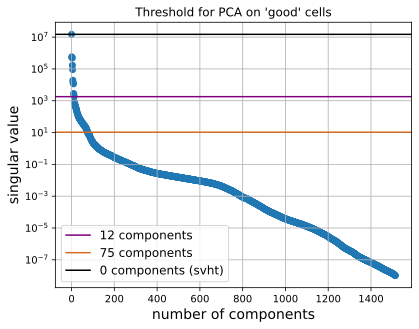

In [13]:
df_good = df[df['type'] == 'uninfected'].copy()
# morphological profile of uninfected cells ('good')
x_good = df_good.drop(
    columns=set(meta_cols).intersection(df.columns)
).to_numpy()

cov_matrix = np.cov(x_good, rowvar=False)
sigma, u = linalg.eigh(cov_matrix, check_finite=True)
rank = min(*x_good.shape) - 1
sigma = sigma[::-1]
# remove values under ~float precision
too_low = len(sigma[sigma>1e-8])
rank = min(rank, too_low)

plt.scatter(range(rank), sigma[:rank])

# manual threshold = 10^3
thresh = sigma[sigma >= 10**3][-1]
n_comp = int(np.where(sigma == thresh)[0][0])
plt.axhline(thresh, c='purple', label=f'{n_comp} components')

# manual threshold = 10
thresh = sigma[sigma >= 10][-1]
n_comp = int(np.where(sigma == thresh)[0][0])
plt.axhline(thresh, c='chocolate', label=f'{n_comp} components')

# optimal threshold for the PCA of 'good' cells
thresh = int(maha.svht(x_good))
plt.axhline(sigma[thresh], c='k', label=f'{thresh} components (svht)')

plt.grid()
plt.yscale('log')
plt.legend(fontsize=12)
plt.xlabel('number of components', fontsize=14)
plt.ylabel('singular value', fontsize=14)
plt.title("Threshold for PCA on 'good' cells")
plt.show()

#### Compute predictions (similarity to uninfected in terms of distance and probability)

In [14]:
# Omit 'uninfected' from the set for predictions
df_cells = df[df['type'] != 'uninfected']
x_cells = df_cells.drop(
    columns=set(meta_cols).intersection(df.columns)
).copy()

n_components = 18  # we use # components sufficient to make uninfected and infected cells distinguishable
df_good = df[df['type'] == 'uninfected'].copy()
x_good = df_good.drop(
    columns=set(meta_cols).intersection(df.columns)
).copy()

dist_pred = maha.get_distance(x_good, x_cells, n_components=n_components)
df_dist = pd.DataFrame(dist_pred, columns=['distance'])

proba_pred = maha.get_proba(x_good, x_cells, n_components=n_components)
df_proba = pd.DataFrame(proba_pred, columns=['proba'])

#### Concatenate predictions


In [15]:
predictions = pd.concat(
    [
        df_cells[
            ['type', 'batch_id_1', 'batch_id_2', 'conc_1', 'conc_2']
        ].reset_index(drop=True), 
        df_dist,
        df_proba,
    ], 
    axis=1,
)

predictions.head()

type batch_id_1 batch_id_2  conc_1  conc_2   distance     proba
0  combo  BJ1897713  BJ1894563    0.83    0.83   5.632891  0.023665
1  combo  BJ1897713  BJ1894563    0.83    0.83   4.126773  0.521026
2  combo  BJ1897713  BJ1894563    0.83    0.83   6.782581  0.000296
3  combo  BJ1897713  BJ1894563    0.83    0.83  11.371209  0.000000
4  combo  BJ1897713  BJ1894563    0.83    0.83   6.996991  0.000108

#### Ranking all compounds by distance

Rows in the ranking below correspond to different compounds at different concentrations, i.e., we average over replicates.

In [16]:
def quantile(n):
    def quantile_(x):
        return x.quantile(n)
    quantile_.__name__ = f'q_{n*100:.0f}'
    return quantile_

selected_columns = predictions[[
    'type',
    'batch_id_1',
    'batch_id_2',
    'conc_1',
    'conc_2',
    'distance',
    'proba',
]].copy()

# Aggregate replicates
average_predictions = selected_columns.groupby(
    by=['type', 'batch_id_1', 'batch_id_2', 'conc_1', 'conc_2'], 
    as_index=False
).agg({
    'distance': [quantile(.25), quantile(.75), 'median'],
    'proba': [quantile(.25), quantile(.75), 'median'],
})

# Rename columns
custom_columns = [''.join(col) for col in average_predictions.columns.to_flat_index() if not col[1]]
custom_columns += ['_'.join(col) for col in average_predictions.columns.to_flat_index() if col[1]]
average_predictions.columns = custom_columns

# Sort by distance to non-infected
average_predictions.sort_values(by=['distance_median'], ascending=True, inplace=True)

# Quantiles are written as plus/minus to the median
for metric in ('distance', 'proba'):
    average_predictions[f'{metric}_q_75'] = average_predictions[f'{metric}_q_75'] - average_predictions[f'{metric}_median']
    average_predictions[f'{metric}_q_25'] =  average_predictions[f'{metric}_median'] - average_predictions[f'{metric}_q_25']

os.makedirs("output", exist_ok=True)
average_predictions.reset_index(inplace=True, drop=True)
average_predictions.to_csv("output/covid_combo_ranked.csv", sep=';', index=False)
average_predictions.head(5)

type batch_id_1 batch_id_2  conc_1  conc_2  distance_q_25  distance_q_75  \
0  combo  BJ1898404  BJ1895608    3.33    0.83       0.145968       0.546275   
1  combo  BJ1895608  BJ1898404    0.83    3.33       0.145968       0.546275   
2  combo  BJ1898163  BJ1895296    3.33    0.17       0.322831       1.185026   
3  combo  BJ1895296  BJ1898163    0.17    3.33       0.322831       1.185026   
4  combo  BJ1895621  BJ1894069    3.33    3.33       0.162741       0.865805   

   distance_median  proba_q_25  proba_q_75  proba_median  
0         3.372166    0.240411    0.039827      0.877932  
1         3.372166    0.240411    0.039827      0.877932  
2         3.519109    0.600472    0.097836      0.826785  
3         3.519109    0.600472    0.097836      0.826785  
4         3.539127    0.451573    0.057659      0.818960

In [17]:
# Enumerate each combination with 'combo_id'
combos = (average_predictions['type'] == 'combo')
df_combos = average_predictions[combos].copy()
df_combos['ids_in_combo'] = df_combos.apply(
    lambda x: frozenset([x['batch_id_1'], x['batch_id_2']]),
    axis=1
)
combinations = set(df_combos['ids_in_combo'])
# dict for mapping
mapping = {pair: count for count, pair in enumerate(combinations)}
df_combos['combo_id'] = df_combos['ids_in_combo'].map(mapping).astype('int')
average_predictions['combo_id'] = -1
average_predictions.loc[combos, 'combo_id'] = df_combos['combo_id']

average_predictions.head()

type batch_id_1 batch_id_2  conc_1  conc_2  distance_q_25  distance_q_75  \
0  combo  BJ1898404  BJ1895608    3.33    0.83       0.145968       0.546275   
1  combo  BJ1895608  BJ1898404    0.83    3.33       0.145968       0.546275   
2  combo  BJ1898163  BJ1895296    3.33    0.17       0.322831       1.185026   
3  combo  BJ1895296  BJ1898163    0.17    3.33       0.322831       1.185026   
4  combo  BJ1895621  BJ1894069    3.33    3.33       0.162741       0.865805   

   distance_median  proba_q_25  proba_q_75  proba_median  combo_id  
0         3.372166    0.240411    0.039827      0.877932       704  
1         3.372166    0.240411    0.039827      0.877932       704  
2         3.519109    0.600472    0.097836      0.826785       332  
3         3.519109    0.600472    0.097836      0.826785       332  
4         3.539127    0.451573    0.057659      0.818960       645

In [18]:
def plot_compounds_separately(compounds, negative=None, n_components=None, metric='distance'):

    if n_components is None:
        raise ValueError("Please, specify the number of components used in Mahalanobis distance computation")

    y_metric = f"{metric}_median"
    y_metric_q_25 = f"{metric}_q_25"
    y_metric_q_75 = f"{metric}_q_75"

    drugs = compounds[compounds['type'].isin(['combo', 'single'])]

    conf_intervals = [0.5, 0.75]
    healthy_left = dict()
    healthy_right = dict()
    for conf in conf_intervals:
        if metric == 'distance':
            left_sq, right_sq = stats.chi2.interval(confidence=conf, df=n_components)
            healthy_left[conf], healthy_right[conf] = np.sqrt(left_sq), np.sqrt(right_sq)        
        elif metric == 'proba':
            healthy_left[conf],  healthy_right[conf] = conf, 1
        
    if negative is not None:
        # neg_median = negative[y_metric].iloc[0]
        neg_left = negative[y_metric].iloc[0] - negative[y_metric_q_25].iloc[0]
        neg_right = negative[y_metric].iloc[0] + negative[y_metric_q_75].iloc[0]

    if metric == 'distance':
        if negative is None:
            ymin, ymax = min(healthy_left.values()), 3*max(healthy_right.values())
        else:
            ymin, ymax = min(healthy_left.values()), neg_right + 1
    elif metric == 'proba':
        ymin, ymax = 0, 1

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    batch_ids = drugs['batch_id_1'].unique()
    cols = 4
    rows = len(batch_ids) // cols + 1
    fig, axs = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
    fig.tight_layout()

    # Iterate over compounds
    for r in range(rows):
        for c in range(cols):
            i = r * 4 + c
            if i == len(batch_ids):
                break
            batch_id = batch_ids[i]
            combo_ids = drugs[drugs['batch_id_1'] == batch_id]['combo_id'].unique()
            if len(combo_ids) > 1:
                # Plot combinations containing given drug
                for j, combo_id in enumerate(combo_ids):
                    compound = drugs[(drugs['batch_id_1'] == batch_id) & (drugs['combo_id'] == combo_id)]
                    conc_2 = np.sort(compound['conc_2'].unique())
                    for k, p_conc in enumerate(conc_2):
                        selected = compound[compound['conc_2'] == p_conc]
                        sort_arg = np.argsort(selected['conc_1'])
                        conc_1 = selected['conc_1'].to_numpy()[sort_arg]
                        y_values = selected[y_metric].to_numpy()[sort_arg]
                        y_perc_25 = selected[y_metric_q_25].to_numpy()[sort_arg]
                        y_perc_75 = selected[y_metric_q_75].to_numpy()[sort_arg]
                        linestyle = '-' if k == 0 else '--'
                        # print(selected['name_1'].iloc[0], linestyle)
                        axs[r, c].errorbar(
                            conc_1, y_values, yerr=[y_perc_25, y_perc_75], 
                            capsize=2, elinewidth=1.5, ls=linestyle, c=colors[j % len(colors)],
                            label=(selected['name_2'].iloc[0] + f' at {p_conc}')
                        )
            else:
                # Plot a single drug
                compound = drugs[(drugs['batch_id_1'] == batch_id)]
                sort_arg = np.argsort(compound['conc_1'])
                conc_1 = compound['conc_1'].to_numpy()[sort_arg]
                y_values = compound[y_metric].to_numpy()[sort_arg]
                y_perc_25 = compound[y_metric_q_25].to_numpy()[sort_arg]
                y_perc_75 = compound[y_metric_q_75].to_numpy()[sort_arg]
                axs[r, c].errorbar(
                    conc_1, y_values, yerr=[y_perc_25, y_perc_75], 
                    capsize=2, elinewidth=1.5, label='single'
                )

            x_ticks = drugs[drugs['batch_id_1'] == batch_id]['conc_1'].unique()
            if len(x_ticks) <= 1:
                x_ticks = [drugs['conc_1'].min(), drugs['conc_1'].max()]
            
            # Uninfected cells - confidence intervals
            for i, conf in enumerate(conf_intervals):
                label = "Uninfected" if i == 0 else None
                axs[r, c].fill_between(x_ticks, healthy_left[conf], healthy_right[conf], 
                                color='royalblue', alpha=0.5*(1-conf)**0.5, 
                                zorder=1, label=label
                    )
            axs[r, c].text(
                (x_ticks[0]+x_ticks[-1])/2, (healthy_left[conf]+healthy_right[conf])/2, 
                'Uninfected', ha='center', va='center', alpha=0.4
            )
            
            if negative is not None:
                # Negative state (DMSO)
                axs[r, c].fill_between(
                    x_ticks, neg_left, neg_right, 
                    color='k', alpha=0.25, zorder=1,
                )
                axs[r, c].text(
                    (x_ticks[0]+x_ticks[-1])/2, (neg_left+neg_right)/2,
                    'DMSO', ha='center', va='center', alpha=0.4,
                )

            axs[r, c].set_title(compound['name_1'].iloc[0])
            axs[r, c].set_xticks(x_ticks)
            # axs[r, c].set_xscale('log')
            axs[r, c].set_ylim(ymin, ymax)
            if c == 0:
                axs[r, c].set_ylabel(f'{metric}')
            if r == rows - 1:
                axs[r, c].set_xlabel('concentration')

    os.makedirs("output", exist_ok=True)
    fig.savefig(f"output/Covid-combo-{metric}.png", dpi=300, bbox_inches="tight")


In [19]:
negative = average_predictions[average_predictions['type'] == 'infected'].copy()    # infected & non-treated
compounds = average_predictions[average_predictions['type'].isin(['combo', 'single'])].copy()

In [20]:
# If we want to use batch_id's as compound identifiers
compounds['name_1'] = compounds['batch_id_1']
compounds['name_2'] = compounds['batch_id_2']

In [21]:
# If we want to use compound names instead of batch_id's
with open("data/id_to_name.txt", 'r') as file:
    table = file.readlines()
id_to_name = {}
for i, line in enumerate(table):
    id_, name = line.rstrip().split('\t')
    id_to_name[id_] = name

def fill_missing_name(batch_id):
    if batch_id in id_to_name:
        return id_to_name[batch_id]
    else:
        return f"Batch_id: {batch_id}"

compounds['name_1'] = compounds['batch_id_1'].map(fill_missing_name)
compounds['name_2'] = compounds['batch_id_2'].map(fill_missing_name)

In [22]:
plot_compounds_separately(compounds, negative, n_components)

In [23]:
# plot_compounds_separately(compounds, negative, n_components, metric='proba')

In [24]:
# # Run this cell to install the library for interactive graphs

# !pip3 install plotly
# !pip3 install --upgrade nbformat

In [25]:
import plotly.express as px


def plot_one_compound(compounds, batch_id, negative=None, n_components=None, metric='distance'):

    if n_components is None:
        raise ValueError("Please, specify the number of components used in Mahalanobis distance computation")

    y_metric = f"{metric}_median"
    y_metric_q_25 = f"{metric}_q_25"
    y_metric_q_75 = f"{metric}_q_75"

    compound = compounds[compounds['batch_id_1'] == batch_id].copy()
    grouped = compound.groupby(by='name_2').agg({'conc_2': 'min'})
    # Use solid line for one concentration of the second drug
    # and dashed line for another concentration
    compound['line_dash'] = compound.apply(
        lambda x: 
            'solid' if (x['conc_2'] == grouped.loc[x['name_2'], 'conc_2']) 
            else 'dash', 
        axis=1
    )
    compound['line_name'] = compound.apply(
        lambda x: x['name_2']+' at '+str(x['conc_2']),
        axis=1
    )
    line_dash_map = pd.Series(
        compound['line_dash'].values, index=compound['line_name']
    ).to_dict()

    fig = px.line(
        compound.sort_values(by='conc_1'), x='conc_1', y=y_metric,
        color='name_2', line_dash='line_name', line_dash_map=line_dash_map,
        width=800, height=400, markers=True, 
        error_y=y_metric_q_75, error_y_minus=y_metric_q_25,
    )
    # update labels for the legend
    def crop_name(name):
        new_name = name.split(', ')[-1]
        return new_name
    fig.for_each_trace(lambda t: t.update(
            name=crop_name(t.name),
            legendgroup=crop_name(t.name),
            hovertemplate=t.hovertemplate.replace(t.name, crop_name(t.name))
        )
    )

    # Healthy cells - confidence intervals
    for i, conf in enumerate([0.5, 0.75]):
        label = dict(
            text="Uninfected", font=dict(size=15, color="black"), textposition="middle left"
        ) if i == 0 else None

        if metric == 'distance':
            left, right = stats.chi2.interval(confidence=conf, df=n_components)
            left, right = np.sqrt(left), np.sqrt(right)
            
        elif metric == 'proba':
            left, right = conf, 1

        fig.add_hrect(
            type="rect",
            y0=left, y1=right,
            fillcolor="royalblue", opacity=0.5*(1-conf)**0.5,
            layer="below", line_width=0, label=label
        )

    # Negative state (DMSO)
    if negative is not None:
        conc = range(0, 31, 1)
        median = negative[y_metric].iloc[0]
        neg_left = median - negative[y_metric_q_25].iloc[0]
        neg_right = median + negative[y_metric_q_75].iloc[0]
        fig.add_hrect(
            type="rect",
            y0=neg_left, y1=neg_right,
            fillcolor="grey", opacity=0.25,
            layer="below", line_width=0,
            label=dict(
                text="DMSO", font=dict(size=15, color="black"), textposition="middle left"
            )
        )

    if metric == 'distance':
        if negative is not None:
            ymin, ymax = left, neg_right + 1
        else:
            ymin, ymax = left, max(compound[y_metric]+compound[y_metric_q_75])
    elif metric == 'proba':
        ymin, ymax = 0, 1

    conc = np.unique(compounds['conc_1'])
    fig.update_xaxes(title_text="concentration", gridcolor='lightgrey', type="log", tickvals=conc)
    if metric == 'distance':
        # fig.update_yaxes(title_text='distance', gridcolor='lightgrey', type="log", tickvals=[1, 5, 10, 100], range=[ymin, ymax])
        fig.update_yaxes(title_text='distance', gridcolor='lightgrey', range=[ymin, ymax])
    elif metric == 'proba':
        fig.update_yaxes(title_text='probability', gridcolor='lightgrey', tickvals=[1, 5, 10, 100])

    fig.update_layout(
        title_text=compound['name_1'].iloc[0],
        plot_bgcolor='white',
        legend_title="Pair",
    )

    fig.show()


In [26]:
sel_batch_id = 'BJ1895013'  # 'BJ1895608'
# sel_batch_id = 'DO8167002'    # antiviral

plot_one_compound(compounds, batch_id=sel_batch_id, negative=negative, n_components=n_components)

In [27]:
plot_one_compound(compounds, batch_id=sel_batch_id, negative=negative, n_components=n_components, metric='proba')